In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

In [192]:
dataframe = pd.read_csv("./laptop_price.csv", encoding='ISO-8859-1')
print("--columns")
print(dataframe.columns)

print("--One training example")
print(dataframe.iloc[0,:])


--columns
Index(['laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight',
       'Price_euros'],
      dtype='object')
--One training example
laptop_ID                                            1
Company                                          Apple
Product                                    MacBook Pro
TypeName                                     Ultrabook
Inches                                            13.3
ScreenResolution    IPS Panel Retina Display 2560x1600
Cpu                               Intel Core i5 2.3GHz
Ram                                                8GB
Memory                                       128GB SSD
Gpu                       Intel Iris Plus Graphics 640
OpSys                                            macOS
Weight                                          1.37kg
Price_euros                                    1339.69
Name: 0, dtype: object


In [193]:
print("--Unique value count in each category")
for column in dataframe.columns:
    print(column, "unique values:", len(dataframe[column].unique()))


--Unique value count in each category
laptop_ID unique values: 1303
Company unique values: 19
Product unique values: 618
TypeName unique values: 6
Inches unique values: 18
ScreenResolution unique values: 40
Cpu unique values: 118
Ram unique values: 9
Memory unique values: 39
Gpu unique values: 110
OpSys unique values: 9
Weight unique values: 179
Price_euros unique values: 791


In [194]:
print("Number of duplicated rows", dataframe.duplicated().sum())
print("Nan in dataset \n", dataframe.isna().sum())

Number of duplicated rows 0
Nan in dataset 
 laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64


In [195]:
print("Data type of each column \n", dataframe.dtypes)

Data type of each column 
 laptop_ID             int64
Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price_euros         float64
dtype: object


#### Visualize

<BarContainer object of 10 artists>

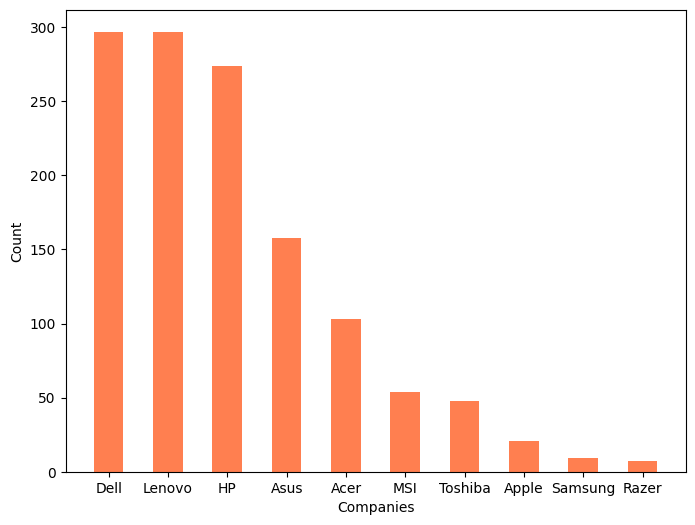

In [196]:
company_count = dataframe["Company"].value_counts()
plt.figure(figsize=(8,6))
plt.xlabel("Companies")
plt.ylabel("Count")
plt.bar(company_count.index[0:10], company_count.values[0:10], color="coral", width=.5)

<BarContainer object of 6 artists>

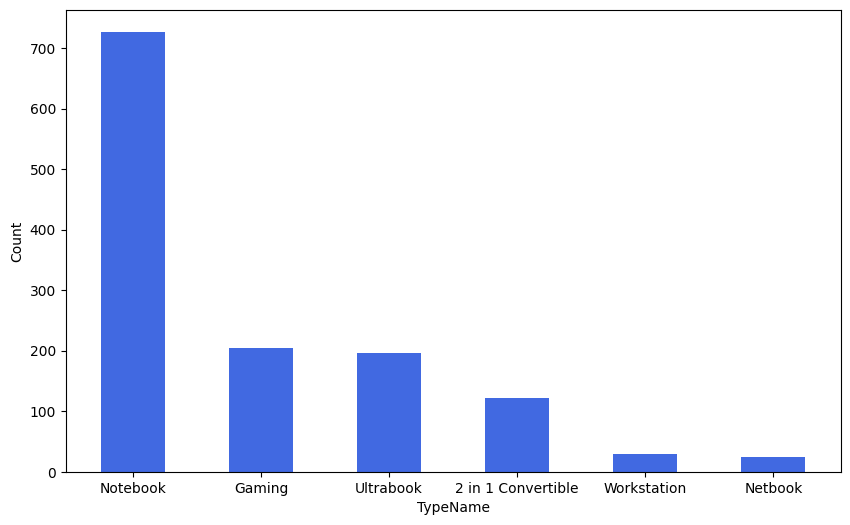

In [197]:
type_count = dataframe["TypeName"].value_counts()
plt.figure(figsize=(10,6))
plt.xlabel("TypeName")
plt.ylabel("Count")
plt.bar(type_count.index[0:10], type_count.values[0:10], color="royalblue", width=.5)

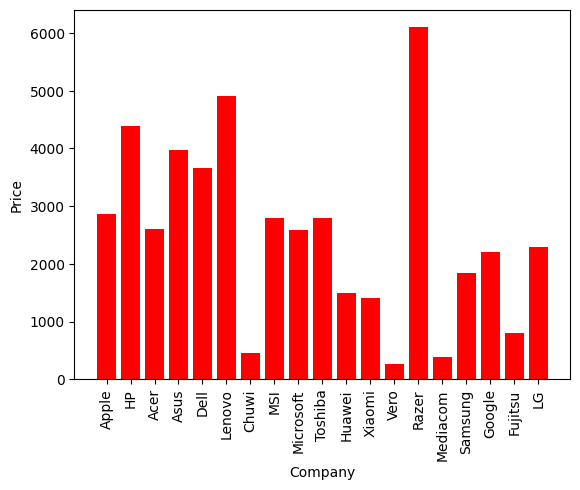

In [198]:
plt.bar(dataframe["Company"], dataframe["Price_euros"], color="red")
plt.xlabel("Company")
plt.ylabel("Price")
plt.xticks(rotation="vertical")
plt.show()

In [199]:
dataframe.drop(columns=["laptop_ID"], inplace=True) #droping the id column

In [200]:
dataframe["Weight"] = dataframe["Weight"].str.replace("kg", "") #getting rid of 'kg' from Weight column
dataframe["Ram"] = dataframe["Ram"].str.replace("GB", "") #getting rid of 'GB' from Ram column

In [201]:
dataframe["Weight"] = dataframe["Weight"].astype("float32")
dataframe["Ram"] = dataframe["Ram"].astype("int32")

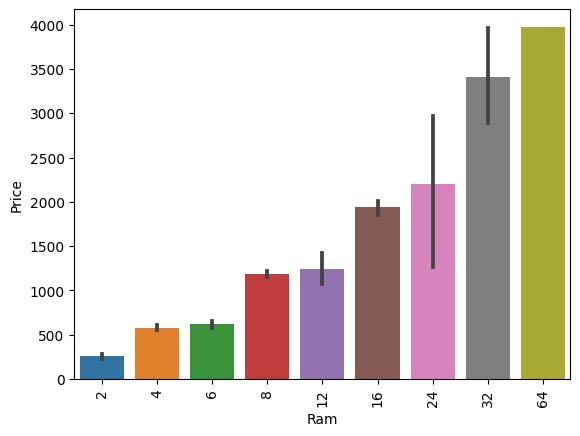

In [202]:
sns.barplot(x=dataframe["Ram"], y=dataframe["Price_euros"])
plt.xlabel("Ram")
plt.ylabel("Price")
plt.xticks(rotation="vertical")
plt.show()

In [203]:
#--Features processed
#ram
#weight
#company
#typename
#memory

In [204]:
#feature engineering 'Memory' column
dataframe["isHDD"] = dataframe["Memory"].str.contains("HDD", case=False).astype(int)
dataframe["isSSD"] = dataframe["Memory"].str.contains("SSD", case=False).astype(int)
dataframe["other_type_storage"] = (~dataframe["Memory"].str.contains(r'\bHDD\b|\bSSD\b', case=False, regex=True)).astype(int)
size_arr = []

for i in dataframe["Memory"]:
    capacity = i.split(" ")[0]
    giga_tera = capacity[-2] + capacity[-1]
    memory_size = capacity[0:-2]
    if giga_tera == "TB":
        size = float(memory_size) * 1024
        size_arr.append(size)
    else:
        size = float(memory_size)
        size_arr.append(size)

dataframe["memory_capacity"] = pd.Series(size_arr)

<BarContainer object of 2 artists>

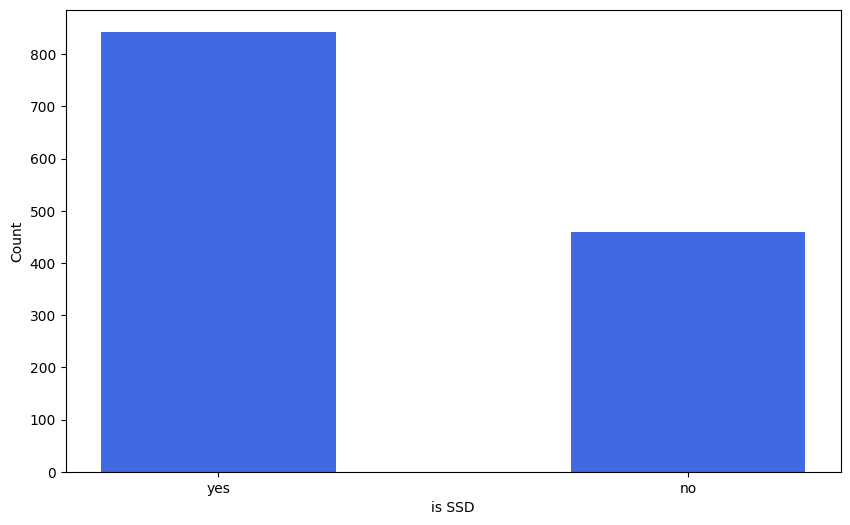

In [205]:
ssd_count = dataframe["isSSD"].value_counts()
plt.figure(figsize=(10,6))
plt.xlabel("is SSD")
plt.ylabel("Count")
plt.bar(["yes", "no"], ssd_count.values, color="royalblue", width=.5)

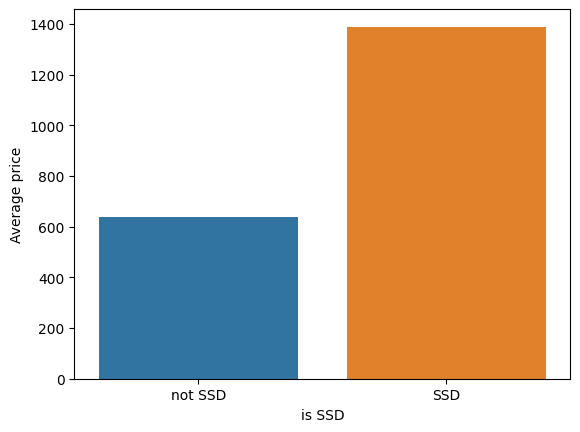

In [206]:
average_prices = dataframe.groupby('isSSD')['Price_euros'].mean()
sns.barplot(x=average_prices.index, y=average_prices.values)
plt.xlabel("is SSD")
plt.ylabel("Average price")
plt.xticks(average_prices.index, ["not SSD", "SSD"])
plt.show()

In [207]:
#feature engineering 'Cpu' column
dataframe["cpu_intel_i3"] = dataframe["Cpu"].str.contains("Intel Core i3", case=False).astype(int)
dataframe["cpu_intel_i5"] = dataframe["Cpu"].str.contains("Intel Core i5", case=False).astype(int)
dataframe["cpu_intel_i7"] = dataframe["Cpu"].str.contains("Intel Core i7", case=False).astype(int)
other_intel_cpu_condition = r'\bIntel Core i3\b|\bIntel Core i5\b|\bIntel Core i7\b|\bAMD\b'
dataframe["cpu_other_intel"] = (~dataframe["Cpu"].str.contains(other_intel_cpu_condition, case=False, regex=True)).astype(int)
dataframe["cpu_amd"] = dataframe["Cpu"].str.contains("AMD", case=False).astype(int)


In [208]:
new_df = pd.DataFrame(dataframe)
feature_tobe_ordinal = ["Gpu", "Company", "ScreenResolution"]
feature_tobe_oneHotEncoded = ["OpSys", "TypeName"]

for feature in feature_tobe_ordinal:
    enc = OrdinalEncoder()
    enc.fit(dataframe[[feature]])
    transformed_data = enc.transform(dataframe[[feature]])
    transformed_df = pd.DataFrame(transformed_data, columns=[feature])
    new_df = pd.concat([new_df, transformed_df], axis=1)

for feature in feature_tobe_oneHotEncoded:
    enc = OneHotEncoder()
    enc.fit(dataframe[[feature]])
    transformed_data = enc.transform(dataframe[[feature]]).toarray()
    column_names = enc.get_feature_names_out([feature])
    transformed_df = pd.DataFrame(transformed_data, columns=column_names)
    new_df = pd.concat([new_df, transformed_df], axis=1)

#for gpu, memory, Company, Product, Inches, ScreenResolution, Cpu use ordinal encoder
#for OpSys, Ram, TypeName use oneHotEncoder
#turn weight column numeric

"""
laptop_ID                                            1
Company                                          Apple -
Product                                    MacBook Pro
TypeName                                     Ultrabook -
Inches                                            13.3
ScreenResolution    IPS Panel Retina Display 2560x1600
Cpu                               Intel Core i5 2.3GHz -
Ram                                                8GB -
Memory                                       128GB SSD -
Gpu                       Intel Iris Plus Graphics 640
OpSys                                            macOS -
Weight                                          1.37kg -
Price_euros                                    1339.69
"""
print("most frequent item in product column: ", dataframe["Product"].mode().iloc[0])
product_count = dataframe["Product"].value_counts()
print("Top 20 most frequent items \n",product_count.head(20))

most frequent item in product column:  XPS 13
Top 20 most frequent items 
 Product
XPS 13                30
Inspiron 3567         29
250 G6                21
Legion Y520-15IKBN    19
Vostro 3568           19
Inspiron 5570         18
ProBook 450           18
Alienware 17          15
Inspiron 5567         14
Satellite Pro         13
EliteBook 840         12
Latitude 5580         12
ThinkPad X1           12
Aspire 3              12
Inspiron 7567         10
EliteBook 850         10
MacBook Pro           10
EliteBook 820          9
Inspiron 3552          9
XPS 15                 9
Name: count, dtype: int64


In [209]:
dataframe = pd.read_csv("./laptop_price.csv", encoding='ISO-8859-1')
first_product_word = dataframe["Product"].str.split().str[0]
first_word_value_count = first_product_word.value_counts()
print(first_word_value_count.head(20))
items_to_encode = first_word_value_count[first_word_value_count > 6].index.tolist()

print(items_to_encode)

encoder = OrdinalEncoder()
dataframe["encoded_product"] = dataframe["Product"].str.split().str[0]
print("number of items to encode:", len(items_to_encode))
print("items to encode", items_to_encode)

counter = 40
for item in items_to_encode:
    condition = dataframe["encoded_product"] == item
    dataframe.loc[condition, "encoded_product"] = counter
    counter-=1

for item in first_product_word.unique():
    if item not in items_to_encode:
        condition = dataframe["encoded_product"] == item
        dataframe.loc[condition, "encoded_product"] = 50


Product
Inspiron      141
IdeaPad        95
Aspire         63
ThinkPad       62
Latitude       52
ProBook        50
EliteBook      45
XPS            39
Thinkpad       37
Vostro         33
Yoga           33
Rog            27
250            25
Legion         23
Probook        22
VivoBook       20
Chromebook     20
Alienware      19
ZenBook        19
MacBook        19
Name: count, dtype: int64
['Inspiron', 'IdeaPad', 'Aspire', 'ThinkPad', 'Latitude', 'ProBook', 'EliteBook', 'XPS', 'Thinkpad', 'Vostro', 'Yoga', 'Rog', '250', 'Legion', 'Probook', 'VivoBook', 'Chromebook', 'Alienware', 'ZenBook', 'MacBook', 'Tecra', 'Portege', 'ZBook', 'Spectre', 'Satellite', 'Omen', 'Precision', 'ROG', 'Pavilion', 'Elitebook', 'Zenbook', 'V110-15ISK', 'Ideapad', 'Blade', 'Notebook', 'Swift', 'Envy']
number of items to encode: 37
items to encode ['Inspiron', 'IdeaPad', 'Aspire', 'ThinkPad', 'Latitude', 'ProBook', 'EliteBook', 'XPS', 'Thinkpad', 'Vostro', 'Yoga', 'Rog', '250', 'Legion', 'Probook', 'VivoBook',

In [210]:
print(dataframe["ScreenResolution"].unique())

['IPS Panel Retina Display 2560x1600' '1440x900' 'Full HD 1920x1080'
 'IPS Panel Retina Display 2880x1800' '1366x768'
 'IPS Panel Full HD 1920x1080' 'IPS Panel Retina Display 2304x1440'
 'IPS Panel Full HD / Touchscreen 1920x1080'
 'Full HD / Touchscreen 1920x1080' 'Touchscreen / Quad HD+ 3200x1800'
 'IPS Panel Touchscreen 1920x1200' 'Touchscreen 2256x1504'
 'Quad HD+ / Touchscreen 3200x1800' 'IPS Panel 1366x768'
 'IPS Panel 4K Ultra HD / Touchscreen 3840x2160'
 'IPS Panel Full HD 2160x1440' '4K Ultra HD / Touchscreen 3840x2160'
 'Touchscreen 2560x1440' '1600x900' 'IPS Panel 4K Ultra HD 3840x2160'
 '4K Ultra HD 3840x2160' 'Touchscreen 1366x768'
 'IPS Panel Full HD 1366x768' 'IPS Panel 2560x1440'
 'IPS Panel Full HD 2560x1440' 'IPS Panel Retina Display 2736x1824'
 'Touchscreen 2400x1600' '2560x1440' 'IPS Panel Quad HD+ 2560x1440'
 'IPS Panel Quad HD+ 3200x1800'
 'IPS Panel Quad HD+ / Touchscreen 3200x1800'
 'IPS Panel Touchscreen 1366x768' '1920x1080'
 'IPS Panel Full HD 1920x1200'
 'IP

In [211]:
copy_df = new_df.iloc[:, [3, 6, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]]

In [ ]:
copy_df["IPS"] = dataframe["ScreenResolution"].str.contains("IPS", case=False).astype(int)
copy_df["touchscreen"] = dataframe["ScreenResolution"].str.contains("Touchscreen", case=False).astype(int)
copy_df["quad_hd"] = dataframe["ScreenResolution"].str.contains("Quad HD+", case=False).astype(int)
copy_df["full_hd"] = dataframe["ScreenResolution"].str.contains("Full HD", case=False).astype(int)
copy_df["4k"] = dataframe["ScreenResolution"].str.contains("4K", case=False).astype(int)
copy_df["ultra_hd"] = dataframe["ScreenResolution"].str.contains("Ultra HD", case=False).astype(int)

screen_width = []
screen_height = []
for i in dataframe["ScreenResolution"]:
    res = i.split(" ")[-1]
    width = res.split("x")[0]
    screen_width.append(width)
    height = res.split("x")[1]
    screen_height.append(height)

copy_df["screen_width"] = pd.Series(screen_width)
copy_df["screen_height"] = pd.Series(screen_height)

In [213]:
#copy_df["encoded_product"] = dataframe["encoded_product"]

In [215]:
labels = dataframe["Price_euros"]

In [216]:
X_train, X_test, y_train, y_test = train_test_split(copy_df, labels, test_size=.2)

In [217]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1042, 37) (1042,)
(261, 37) (261,)


In [218]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [219]:
ridge = Ridge(alpha=.01)
ridge.fit(X_train, y_train)

Ridge(alpha=0.01)

In [220]:
print("--Linear regression--")
y_test_predict_linear = lr.predict(X_test)
print("Linear regression R2 score", r2_score(y_test_predict_linear, y_test))
print("Linear regression MAE", mean_absolute_error(y_test,y_test_predict_linear))
print("Linear regression MSE", mean_squared_error(y_test,y_test_predict_linear))


print("--Ridge regression--")
y_test_predict_ridge = ridge.predict(X_test)
print("Ridge regression R2 score", r2_score(y_test_predict_ridge, y_test))
print("Linear regression MAE", mean_absolute_error(y_test,y_test_predict_ridge))
print("Linear regression MSE", mean_squared_error(y_test,y_test_predict_ridge))



--Linear regression--
Linear regression R2 score 0.716755710155677
Linear regression MAE 237.68947460004077
Linear regression MSE 115100.8507351958
--Ridge regression--
Ridge regression R2 score 0.7167036648383583
Linear regression MAE 237.71267157127036
Linear regression MSE 115112.51442267383


In [221]:
print(y_test.values[0:7])
print(y_test_predict_linear[0:7])

[1958.9  1279.    252.36  949.   1499.   1099.    589.  ]
[1722.52499634 2869.12577447  137.06832928 1145.18335465 1249.32098759
 1056.94799699  809.85390939]


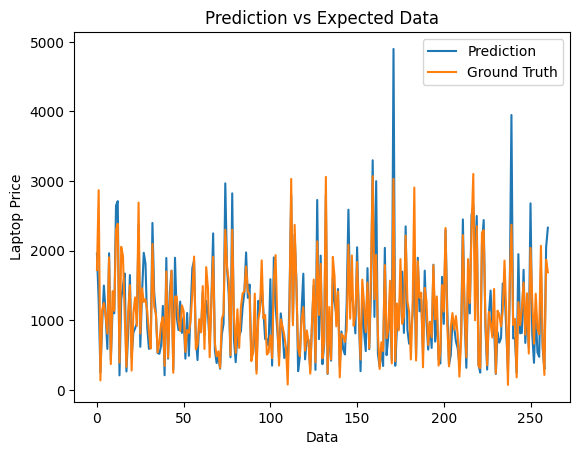

In [222]:
plt.plot(y_test.values)
plt.plot(y_test_predict_linear)
plt.title('Prediction vs Expected Data')
plt.xlabel('Data')
plt.ylabel('Laptop Price')
plt.legend(labels=['Prediction','Ground Truth'])
plt.show()